# Analysis of the State Farm image data

This notebook provides analysis of the provided State Farm data, using Theano and Keras to build the NN.

Note that the data is available from Kaggle here:  
https://www.kaggle.com/c/state-farm-distracted-driver-detection/data


## Set up the environment
First, let's import what we need and set up environment variables, etc.

In [1]:
import theano
theano.config.device = 'gpu'
theano.config.floatX = 'float32'

Exception: Can't change the value of this config parameter after initialization!

In [2]:
# Imports of the relevant libraries
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# These are the locations of the images provided by Kaggle
# Root Dir is needed for Python, but not for create lmdb shell script later... (we need it there too!)
image_root_dir = './imgs/'
train_image_source_dir = "./train/"
test_image_source_dir = "./test/"
driver_image_list = "./driver_imgs_list.csv"

# These are the locations of the images that we will work with 
# Note that as we're continually mix up training and validation drivers/images, 
# then we will store images in one directory and use code to determine whether to train or validate
train_images_dir = "./images/train/"
#validation_images_dir = "./images/validate/" 
test_images_dir = "./images/test/"

# Some more controls
# color type: 1 - grey, 3 - rgb
color_type = 1 
image_width = 224 #80
image_height = 224 #60

## Start by pre-processing the images
There are only 27 different drivers so in order to avoid overfitting, or testing using very similar data to training, we will split the data based on the driver into train and validation sets.

Initially though, let's get the list of drivers, see how many images are available for each driver, and which classification they have been labelled with.


In [3]:
# Training set is in the provided csv file
driver_list = pd.read_csv(driver_image_list)
print "Training data summary: \n{}".format(driver_list.head())

test_image_list = os.listdir(image_root_dir + test_image_source_dir)
print "\nTesting data summary: \n{}".format(test_image_list[0:9])

Training data summary: 
  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

Testing data summary: 
['img_1.jpg', 'img_10.jpg', 'img_100.jpg', 'img_1000.jpg', 'img_100000.jpg', 'img_100001.jpg', 'img_100002.jpg', 'img_100003.jpg', 'img_100004.jpg']


Process images so that they are in an format more suited to training and testing

In [4]:
def get_driver_images_and_classes(driver_list):
    image_list = []
    class_list = []
    total = 0
    for driver_row in [ drvr for drvr in driver_list.iterrows() ]:   # if drvr[1]['subject'] in filter 
        driver = driver_row[1]  # Drop the index created by the Pandas Dataframe
        driver_class = int(driver['classname'][1:])  # Get integer to represent class (eg 'c0' is class '0')
        image_list.append(driver['img'])
        class_list.append(driver_class)
        total += 1
    print "Total number of training images found {}".format(total)
    #Return a list of images and their classification
    return np.array(image_list), np.array(class_list)

# Create a training list of images and classes from the training set
images, classes = get_driver_images_and_classes(driver_list)

Total number of training images found 22424


In [5]:
import cv2

# Process the image, for now this is resize only
# We'll handle colour/greyscale when we load as cv2 does this for us
# TODO - Move directory creation to Python code to be OS independent

def pre_process_image(image):
    processed_img = cv2.resize(image, (image_width, image_height)) 
    return processed_img
    
def create_train_image_repository(images_dest_dir, images_list, class_list, color_type=1):
    print "create_image_repository(): Processing images into {}".format(images_dest_dir)
    copied = 0 
    for f, c in zip(images_list, class_list):
        dest_dir = images_dest_dir + str(c) + "/"
        if os.path.exists(dest_dir) == False:
            !mkdir $dest_dir
        image_filename = image_root_dir + train_image_source_dir + '/c' + str(c) + '/' + f
        if color_type == 1:
            orig_img = cv2.imread(image_filename, 0)
        elif color_type == 3:
            orig_img = cv2.imread(image_filename)
        processed_image = pre_process_image(orig_img)
        cv2.imwrite(images_dest_dir + str(c) + "/" + f, processed_image)
        copied += 1
        if copied % 100 == 0:
            print ".",
    print "\nCopied {} images...Done!".format(copied)
    return copied

def create_test_image_repository(dest_dir, images_list, color_type=1):
    print "create_image_repository(): Processing images into {}".format(dest_dir)
    copied = 0 
    for f in images_list:
        if os.path.exists(dest_dir) == False:
            !mkdir $dest_dir
        image_filename = image_root_dir + test_image_source_dir + f
        if color_type == 1:
            orig_img = cv2.imread(image_filename, 0)
        elif color_type == 3:
            orig_img = cv2.imread(image_filename)
        processed_image = pre_process_image(orig_img)
        cv2.imwrite(dest_dir + f, processed_image)
        copied += 1
        if copied % 100 == 0:
            print ".",
    print "\nCopied {} images...Done!".format(copied)
    return copied

## Pre-process images if required

In [6]:
# Start by clearing out any old data (ignore failures here if the directory doesn't exist)
# TODO - Move to Python code to be OS independent

create_repository = False    # True forces creation of the processed images, 
                            # Set to False if this has been done previously
if create_repository:
    print "Deleting old repositories if they exist, this may take a while..."
    !rm -rf $train_images_dir
    #!rm -rf $validation_images_dir
    !rm -rf $test_images_dir

    # Create directories
    !mkdir -p $train_images_dir
    #!mkdir -p $validation_images_dir
    !mkdir -p $test_images_dir

    create_test_image_repository(test_images_dir, test_image_list, color_type=color_type)
    create_train_image_repository(train_images_dir, images, classes, color_type=color_type)


## Create train and validation data sets

Seperate the drivers into a training and validation set.  To ensure we don't have overfitting (the training set and the validation set contain the same or similar images) we will split on drivers, so a driver can only appear in training or validation but not both.


In [7]:
driver_ids = []
for id, driver in driver_list.iterrows():
    if driver['subject'] not in driver_ids:
        driver_ids.append(driver['subject'])
print "Found {} drivers: {}".format(len(driver_ids), driver_ids)

Found 26 drivers: ['p002', 'p012', 'p014', 'p015', 'p016', 'p021', 'p022', 'p024', 'p026', 'p035', 'p039', 'p041', 'p042', 'p045', 'p047', 'p049', 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p075', 'p081']


In [8]:
def render_image(image_filename):
    print "render_image(): Rendering {}".format(image_filename)
    image = cv2.imread(image_filename, color_type_global)
    plt.axis("off")
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(image)
    plt.show() 
    #print image.shape
    #plt.imshow(image)

Split into train and validation data tests (split = percentage to have in training set)
and then create X_train, y_train, X_valid, y_valid

In [9]:
from keras.utils import np_utils

def create_train_validation_data(driver_list, filter):
    #sample = driver_list[driver_list.subject.isin(filter)].ix[:, 'classname':'img']
    images = []
    labels = []
    total = 0
    for driver_row in [ drvr for drvr in driver_list[driver_list.subject.isin(filter)].ix[:, 'classname':'img'].iterrows() ]:   # if drvr[1]['subject'] in filter 
        driver = driver_row[1]  # Drop the index created by the Pandas Dataframe
        #print driver
        label = int(driver['classname'][1:])
        filename = train_images_dir + str(label) + "/" + driver['img']
        if color_type == 1:
            image = cv2.imread(filename, 0).transpose()  # Is the color_type needed here as these are pre-processed images??
        elif color_type == 3:
            image = cv2.imread(filename).transpose()     # Is the color_type needed here as these are pre-processed images??
        images.append(image)
        labels.append(label)
        total += 1
        if total % 100 == 0:
            print ".",
    print "\nProcessed {} rows.".format(total)
    
    images = np.array(images, dtype=np.uint8)
    images = images.reshape(images.shape[0], color_type, image_width, image_height)
    images = images.astype('float32')
    images /= 255
    
    labels = np.array(labels, dtype=np.uint8)
    labels = np_utils.to_categorical(labels, 10)

    return images, labels



Using Theano backend.


In [10]:
def split_drivers_into_train_and_validate(driver_list, split = 1):
    driver_valid_list = []
    # Take a random sample of drivers into the training list
    driver_train_list = np.random.choice(driver_list, int(len(driver_list)*split), replace = False)
    # Take the remaining drivers into the validation list
    driver_valid_list = [ driver for driver in driver_list if driver not in driver_train_list]
    return driver_train_list, driver_valid_list
    
#X_train, X_test, y_train, y_test = train_test_split(X_all.ix[rows], student_data[target_col].ix[rows], test_size=test_size)

training_list, validation_list = split_drivers_into_train_and_validate(driver_ids)
print "Driver train list: {}".format(training_list)
print "Driver validation list: {}".format(validation_list)

Driver train list: ['p051' 'p075' 'p035' 'p050' 'p066' 'p022' 'p041' 'p012' 'p026' 'p061'
 'p056' 'p002' 'p039' 'p081' 'p042' 'p047' 'p064' 'p024' 'p021' 'p015'
 'p049' 'p016' 'p045' 'p014' 'p052' 'p072']
Driver validation list: []


In [11]:
# TODO - Add in random ordering of training data!!
# index = np.random.choice(range(0, num_training_samples), num_training_samples, replace = False) # Random ordering
# ...driver_list[index], training_list[index]
print "Creating training data:"
X_train, y_train = create_train_validation_data(driver_list, training_list)
print "Creating validation data:"
X_valid, y_valid = create_train_validation_data(driver_list, validation_list)





Creating training data:
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 
Processed 22424 rows.
Creating validation data:

Processed 0 rows.


In [12]:
print X_train.shape
print y_train.shape
num_training_samples = X_train.shape[0]
print X_valid.shape
print y_valid.shape
num_validation_samples = X_valid.shape[0]

(22424, 1, 224, 224)
(22424, 10)
(0, 1, 224, 224)
(0, 10)


## Create an inital CNN using Keras
Starting with no pre-loaded weights though as we'll train this with our own data.
Based on example here http://keras.io

TODO: In a future iteration, we'll play about with this architecture and the activation, optimizer and loss functions

In [13]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D  
from keras.layers import Dense, Flatten, Activation, Dropout, MaxPooling1D
from keras.optimizers import Adam, SGD

###Custom Keras Model

In [14]:
def custom_keras_model(num_classes, weights_path=None, w_regularizer = None, b_regularizer = None):
    num_filters = 8      #number of filters to apply/learn in the 1D convolutional layer
    num_pooling = 2
    filter_length = 5     #linear length of each filter (this is 1D)
    num_filters_2 = 8

    #num_filters = 8      #number of filters to apply/learn in the 1D convolutional layer
    #num_pooling = 2
    #filter_length = 2     #linear length of each filter (this is 1D)
    #num_filters_2 = 16
    
    # Create callback for history report
    from keras.callbacks import Callback
    class LossHistory(Callback):
        def on_train_begin(self, logs={}):
            self.losses = []

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
    
    
    #from keras.utils.dot_utils import Grapher
    
    model = Sequential()
    #grapher = Grapher()

    # Now create the NN architecture (version 1)
    # Going with colour for now!!
    model.add(Convolution2D(num_filters, filter_length, filter_length, border_mode="valid", 
                        activation="relu", 
                        W_regularizer = w_regularizer, b_regularizer = b_regularizer,
                        input_shape=(color_type, image_width, image_height)))
    
    # Added
    model.add(MaxPooling2D(pool_size=(num_pooling, num_pooling)))  
    model.add(Dropout(0.25))
    
    model.add(Convolution2D(num_filters_2, filter_length, filter_length, 
                            W_regularizer = w_regularizer, b_regularizer = b_regularizer))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(num_pooling, num_pooling)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, 
              W_regularizer = w_regularizer, b_regularizer = b_regularizer))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, 
              W_regularizer = w_regularizer, b_regularizer = b_regularizer))
    model.add(Activation('softmax'))
    
    if weights_path:
        print "Loading weights from {}".format(weights_path)
        model.load_weights(weights_path)
        

    #model.summary()
    #grapher.plot(model, 'nn_model.png')
    
    # TODO - Handle loading existing weights 
    
    return model, LossHistory

Determine which NN we are going to use, and whether to load weights or train ourselves

In [15]:
def graph_training_loss_history(losses):
    plt.figure(figsize=(6, 3))
    plt.plot(losses)
    plt.ylabel('error')
    plt.xlabel('batch')
    plt.title('training error')
    plt.show()

In [16]:
from sklearn.metrics import log_loss
def get_log_loss_score(model, X_valid, y_valid):
    predictions_valid = model.predict(X_valid, batch_size=128, verbose=1)
    score = log_loss(y_valid, predictions_valid)
    return score

In [17]:
#Configure the network
def compile_model(learning_rate=0.1):
    if keras_model == 'custom':
        model, LossHistory = custom_keras_model(num_classes, weights, w_regularizer, b_regularizer)
        sgd = SGD(lr=learning_rate, decay=0, momentum=0, nesterov=False)
        #sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    elif keras_model == 'vgg16':
        model, LossHistory = vgg16(num_classes, weights)
        sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)

    # Now compile the model
    model.compile(loss=loss_function, optimizer=sgd, metrics=['accuracy'])
    return model, LossHistory

In [18]:
keras_model, weights, train_model = 'custom', None, True
#keras_model, weights, train_model = 'vgg16', 'model/vgg16_weights.h5', False
loss_function='categorical_crossentropy'
from keras.regularizers import l1, l2
w_regularizer = l2(0.1) # Default = None
b_regularizer = l2(0.1) # Default = None
num_classes = 10

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 8, 220, 220)   208         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 8, 110, 110)   0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 8, 110, 110)   0           maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 8, 106, 106)   1608        dropout_1[0][0]                  
___________________________________________________________________________________________

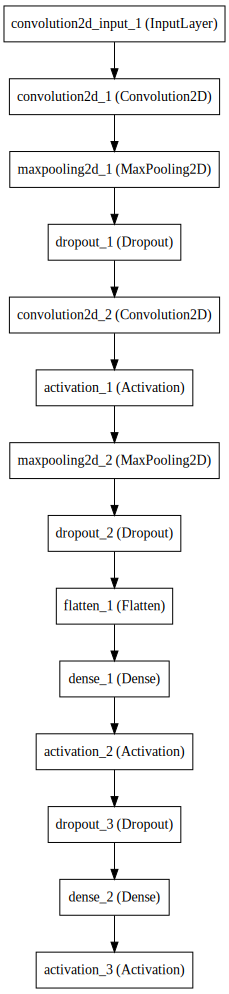

In [19]:
# Compile the model so we can get a view of what it looks like
# Note we'll do this in each training iteration later, but this'll keep the output tidy!
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

model, LossHistory = compile_model()
model.summary()
SVG(model_to_dot(model).create(prog='dot', format='svg'))


## Training 
Train and use validation data to see if we're training effectively!

In [ ]:
batch_size = 32
num_epochs = 5 #10
learning_rate = [0.003, 0.01, 0.03, 0.1, 0.3]

for i in range(0,1):   # range(0,4) if doing multiple learning rates
    #learningrate = learning_rate[i]
    learningrate = 0.03
    print "\n**********************************"
    print "Starting training iteration {} with learning rate {}\n".format(i+1, learningrate)
    model, LossHistory = compile_model(learningrate)
    history = LossHistory()
    #model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=num_epochs,
    #          verbose=1, validation_data=(X_valid, y_valid), shuffle=True,
    #          callbacks=[history]) 
    model.fit(X_train, y_train,            
              batch_size=batch_size, 
              nb_epoch=num_epochs,
              validation_split = 0.15,
              verbose=1,
              shuffle=True,
              callbacks=[history])
    graph_training_loss_history(history.losses)
    #print('Score log_loss: ', get_log_loss_score(model, X_valid, y_valid))
    


**********************************
Starting training iteration 1 with learning rate 0.03

Train on 19060 samples, validate on 3364 samples
Epoch 1/5
 1280/19060 [=>............................] - ETA: 439s - loss: 5.6361 - acc: 0.1039

In [195]:
for layer in model.layers:
    print layer.get_config()
    print layer.get_weights()


{'W_constraint': None, 'b_constraint': None, 'name': 'convolution2d_57', 'activity_regularizer': None, 'trainable': True, 'dim_ordering': 'th', 'nb_col': 2, 'subsample': (1, 1), 'init': 'glorot_uniform', 'bias': True, 'nb_filter': 8, 'activation': 'relu', 'input_dtype': 'float32', 'batch_input_shape': (None, 1, 224, 224), 'W_regularizer': None, 'nb_row': 2, 'b_regularizer': {'l2': 0.009999999776482582, 'name': 'WeightRegularizer', 'l1': 0.0}, 'border_mode': 'valid'}
[array([[[[  1.00727117e+00,  -4.94124293e-01],
         [  3.02565128e-01,   2.76999205e-01]]],


       [[[ -2.18588829e-01,   6.67327762e-01],
         [ -3.59928757e-01,  -1.37905136e-01]]],


       [[[ -9.77293551e-02,  -3.28192919e-01],
         [ -2.55384117e-01,   3.11767161e-02]]],


       [[[  7.53854573e-01,   4.21378255e-01],
         [ -3.35496485e-01,  -6.77961409e-01]]],


       [[[  1.22372055e+00,   3.50442290e-01],
         [  2.22003549e-01,  -1.48298836e+00]]],


       [[[ -2.26020843e-01,  -3.205482

In [196]:
model.save_weights('./model/saved_weights_converged.h5')

###Visualise what the CNN has learnt
Inspired by https://github.com/fchollet/keras/blob/master/examples/conv_filter_visualization.py and https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html

In [149]:
# the name of the layer we want to visualize
# (see model definition at keras/applications/vgg16.py)
layer_name = 'convolution2d_39 '
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layer_output = layer_dict[layer_name].output

# Number of filters
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

KeyError: 'convolution2d_39 '

## Predict based on the test data

In [368]:
# Load the test data
def load_test_images(test_images_dir):
    total = 0
    images = []
    image_ids = []
    test_image_list = os.listdir(test_images_dir)
    num_test_images = len(test_image_list)
    for i in range(0,num_test_images):
        filename = test_images_dir + test_image_list[i]
        image = cv2.imread(filename, 0).transpose()  # Is the color_type needed here as these are pre-processed images??
        images.append(image)  
        image_ids.append(test_image_list[i])
        total += 1
        if total % 100 == 0:
            print ".",
    print "\nProcesses {} rows.".format(total)
    
    images = np.array(images, dtype=np.uint8)
    images = images.reshape(images.shape[0], color_type, image_width, image_height)
    images = images.astype('float32')
    images /= 255
    
    return images, np.array(image_ids)

#test_image_batches = split_test_data(test_images_dir)

In [364]:
test_data, test_ids = load_test_images(test_images_dir)  
print test_data.shape
print test_ids.shape

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [365]:
predictions = model.predict(test_data, batch_size = 128, verbose = 1)

79726/79726 [==============================] - 55s    


In [366]:
print predictions.shape

(79726, 10)


In [367]:
import datetime
def create_submission(predictions, test_ids, test_info):
    result = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result.loc[:, 'img'] = pd.Series(test_ids, index=result.index)
    now = datetime.datetime.now()
    if not os.path.isdir('submission'):
        os.mkdir('submission')
    suffix = test_info + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('submission', 'submission_' + suffix + '.csv')
    result.to_csv(sub_file, index=False)

test_info = 'loss_' + str(score) \
                + '_h_' + str(image_height) \
                + '_w_' + str(image_width) \
                + '_ep_' + str(num_epochs)
create_submission(predictions, test_ids, test_info)

###VGG16 model
From https://gist.github.com/baraldilorenzo/07d7802847aaad0a35d3
Also see:
http://blog.christianperone.com/2016/01/convolutional-hypercolumns-in-python/


In [16]:
def vgg16(num_classes, weights_path=None):
    
    # Create callback for history report
    from keras.callbacks import Callback
    class LossHistory(Callback):
        def on_train_begin(self, logs={}):
            self.losses = []

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))

    model = Sequential()
    
    model.add(ZeroPadding2D((1,1),input_shape=(3,224,224)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    if weights_path:
        print "Loading weights from {}".format(weights_path)
        model.load_weights(weights_path)
        
    # Now replace the top layer with one for our own purposes
    model.layers.pop()
    model.add(Dense(num_classes, activation='softmax'))

    #TODO - Rework model based on 
    return model, LossHistory